In [9]:
import torch
from utils.data_generator import _data_generator_seq2seq
from data_dir import pretrained_3kmer_dir
from sequential_labelling import init_seq2seq_model

dataloader = _data_generator_seq2seq()
model = init_seq2seq_model(pretrained_3kmer_dir)
loss_fn = torch.nn.CrossEntropyLoss()
# print(model)
for step, batch in enumerate(dataloader):
    input_ids, attn_mask, token_type_ids, label = tuple(t for t in batch)
    pred = model(input_ids, attn_mask, token_type_ids)
    # print(pred.shape, label.shape)
    #for p, l in zip(pred, label):
    #    print(p.shape, l.shape)
    #    loss = loss_fn(p, l)
    loss = loss_fn(pred, label)


RuntimeError: Expected target size [1, 11], got [1, 512]

In [ ]:
pred = [
    [   # Sentence 0
        [0.1, 0.2, 0.3, ], # Token 0
        [0.1, 0.2, 0.3, ], # Token 1
        [0.1, 0.2, 0.3, ], # Token 2
        [0.1, 0.2, 0.3, ], # Token 3
        [0.1, 0.2, 0.3, ], # Token 4
    ],
    [   # Sentence 1
        [0.3, 0.4, 0.1, ], # Token 0
        [0.2, 0.3, 0.4, ], # Token 1
        [0.2, 0.3, 0.4, ], # Token 2
        [0.1, 0.2, 0.3, ], # Token 3
        [0.4, 0.1, 0.2, ], # Token 4
    ],
]
import torch
pred = torch.tensor(pred)
pred = torch.nn.Softmax(dim=2)(pred)
print(pred)
print(pred.shape)

label = [
    [1, 1, 1, 1, 1], # Label Sentence 0
    [0, 0, 0, 0, 0], # Label Sentence 1
]
label = torch.tensor(label)
print(label.shape)

fn = torch.nn.CrossEntropyLoss()
loss = fn(pred, label)
print(loss)


In [5]:
import torch
pred = torch.tensor([[0.8]])
label = torch.tensor([[1.0]])

loss_fn = torch.nn.BCELoss()
loss_fn(pred, label)

tensor(0.2231)

In [ ]:
from transformers import BertForTokenClassification, BertModel
from data_dir import pretrained_3kmer_dir

bertForTokenClassification = BertForTokenClassification.from_pretrained(pretrained_3kmer_dir)

In [4]:
from data_dir import chr24_index_csv, chr24_fasta, labseq_dir, labseq_names
chr_indices = [chr24_index_csv]
chr_fastas = [chr24_fasta]
chr_labseq_path = ["{}/{}".format(labseq_dir, fname) for fname in [labseq_names[-1]]]
print(chr_indices)
print(chr_fastas)
print(chr_labseq_path)

['./data/genome/grch38/exon/NC_000024.10.csv']
['./data/chr/NC_000024.10.fasta']
['./data/genome/labseq/chr24.csv']


In [5]:
from data_dir import chr24_index_csv, chr24_fasta, labseq_dir, labseq_names
from data_preparation import generate_sequence_labelling
chr_indices = [chr24_index_csv]
chr_fastas = [chr24_fasta]
chr_labseq_path = ["{}/{}".format(labseq_dir, fname) for fname in [labseq_names[-1]]]
for src, fasta, target in zip(chr_indices, chr_fastas, chr_labseq_path):
    print("Generating sequential labelling for index {}, from fasta {}, to {}: {}".format(src, fasta, target, generate_sequence_labelling(src, fasta, target, do_expand=True, expand_size=512)))

Processing index ./data/genome/grch38/exon/NC_000024.10.csv, with fasta ./data/chr/NC_000024.10.fasta, to seq. labelling ./data/genome/labseq/chr24.csv, expanding [5431760/57226904]

In [1]:
from utils.data_generator import _data_generator_seq2seq
from models.seq2seq import DNABERTSeq2Seq
from data_dir import pretrained_3kmer_dir
dataloader = _data_generator_seq2seq()
model = DNABERTSeq2Seq(pretrained_3kmer_dir)

for step, batch in enumerate(dataloader):
    input_ids, attn_mask, token_type_ids, label = tuple(t for t in batch)
    pred = model(input_ids, attn_mask, token_type_ids)
    # print(pred)

torch.Size([1, 512, 11]) tensor([0.0415, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0046, 0.0000], grad_fn=<SelectBackward0>)
torch.Size([1, 512, 11]) tensor([0.0944, 0.0905, 0.0905, 0.0905, 0.0905, 0.0905, 0.0905, 0.0905, 0.0905,
        0.0909, 0.0905], grad_fn=<SelectBackward0>)
torch.Size([1, 512, 11]) tensor([0.0000, 0.0000, 0.0045, 0.0002, 0.0000, 0.0000, -0.0000, 0.0000, 0.0000,
        0.0000, 0.1010], grad_fn=<SelectBackward0>)
torch.Size([1, 512, 11]) tensor([0.0900, 0.0900, 0.0904, 0.0900, 0.0900, 0.0900, 0.0900, 0.0900, 0.0900,
        0.0900, 0.0996], grad_fn=<SelectBackward0>)
torch.Size([1, 512, 11]) tensor([0.0000, 0.0178, 0.0000, 0.0312, 0.0000, 0.0000, 0.0000, 0.0352, 0.1106,
        0.0142, 0.0000], grad_fn=<SelectBackward0>)
torch.Size([1, 512, 11]) tensor([0.0892, 0.0908, 0.0892, 0.0920, 0.0892, 0.0892, 0.0892, 0.0923, 0.0996,
        0.0904, 0.0892], grad_fn=<SelectBackward0>)
torch.Size([1, 512, 11]) tensor([-0.0000, 0.0000, 0.0000,

In [2]:
s = [0.0944, 0.0905, 0.0905, 0.0905, 0.0905, 0.0905, 0.0905, 0.0905, 0.0905,
        0.0909, 0.0905]
sum(s)

0.9998000000000001

In [1]:
from sequential_labelling import DNABERTSeq2Seq, train, init_adamw_optimizer
from transformers import get_linear_schedule_with_warmup
from data_dir import pretrained_3kmer_dir
import os
from utils.seq2seq import init_seq2seq_model
import json
from utils.data_generator import _data_generator_seq2seq

dataloader = _data_generator_seq2seq()

num_epoch = 10
batch_size = 2
warmup = 10
device = "cuda"
seq2seq_config = json.load(open(os.path.join("models", "config", "config_seq2seq.json"), "r"))
model = init_seq2seq_model(seq2seq_config)
model.to(device)
optimizer = init_adamw_optimizer(model.parameters())
training_steps = len(dataloader) * num_epoch
optim_scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=warmup, num_training_steps=training_steps)
log_path = os.path.join("logs", "seq2seq", "19082022", "log.t-sample.csv")
save_path = os.path.join("result", "seq2seq", "19082022", "t-sample")
model.train()
"""
Play with result.
"""
trained_model = train(model, optimizer, optim_scheduler, dataloader, num_epoch, batch_size, log_path, save_path, device, remove_old_model=True)

c:\.virtualenv\sequence-processing-py39\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
100%|██████████| 4/4 [00:02<00:00,  1.91it/s]


In [2]:
print(trained_model)

DNABERTSeq2Seq(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(69, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)


In [14]:
import torch
loss_function = torch.nn.CrossEntropyLoss()
activation_function = torch.nn.Softmax(dim=2)
pred = torch.tensor([[[0.5, 0.2, 0.3], [0.1, 0.2, 0.7]], [[0.5, 0.2, 0.3], [0.1, 0.2, 0.7]]], requires_grad=True)
pred_activated = activation_function(pred)
print(pred, pred_activated)
labels = torch.tensor([[1, 2], [0, 1]])
print(pred.shape, labels.shape)
for p, l in zip(pred, labels):
    loss = loss_function(p, l)
    print(loss.item())


tensor([[[0.5000, 0.2000, 0.3000],
         [0.1000, 0.2000, 0.7000]],

        [[0.5000, 0.2000, 0.3000],
         [0.1000, 0.2000, 0.7000]]], requires_grad=True) tensor([[[0.3907, 0.2894, 0.3199],
         [0.2546, 0.2814, 0.4640]],

        [[0.3907, 0.2894, 0.3199],
         [0.2546, 0.2814, 0.4640]]], grad_fn=<SoftmaxBackward0>)
torch.Size([2, 2, 3]) torch.Size([2, 2])
1.0038902759552002
1.103890299797058


In [1]:
import torch
from utils.data_generator import _data_generator_mtl
from multitask_learning import init_model_mtl
from data_dir import pretrained_3kmer_dir
model = init_model_mtl(pretrained_path=pretrained_3kmer_dir)
dataloader = _data_generator_mtl(batch_size=2)
loss_function = torch.nn.Softmax(dim=1)
for step, batch in enumerate(dataloader):
    b_input_ids, b_attn_mask, b_label_prom, b_label_ss, b_label_polya = tuple(t for t in batch)
    output = model(b_input_ids, b_attn_mask)
    #print(output["prom"], b_label_prom)
    print(output["ss"].shape, b_label_ss.shape)
    print(output["ss"], b_label_ss)

Data sample 3
torch.Size([2, 2]) torch.Size([2])
tensor([[0.5046, 0.4954],
        [0.5199, 0.4801]], grad_fn=<SoftmaxBackward0>) tensor([0, 1])
torch.Size([1, 2]) torch.Size([1])
tensor([[0.5440, 0.4560]], grad_fn=<SoftmaxBackward0>) tensor([0])


In [1]:
from utils.seq2seq import init_seq2seq_model
import json
import os
model = init_seq2seq_model(json.load(open(os.path.join("models", "config", "config_seq2seq.json"), 'r')))
model

DNABERTSeq2Seq(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(69, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)


In [2]:
from utils.seq2seq import init_seq2seq_model
import json
import os
model = init_seq2seq_model(json.load(open(os.path.join("models", "config", "config_seq2seq_norm.json"), 'r')))
model

DNABERTSeq2Seq(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(69, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)


In [5]:
from utils.seqlab import init_seqlab_model
import json
import os
model = init_seqlab_model(json.load(open(os.path.join("models", "config", "config_seq2seq_multiple.json"), 'r')))
model

DNABERTSeqLab(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(69, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
 

In [6]:
from utils.seqlab import init_seqlab_model
import json
import os
model = init_seqlab_model(json.load(open(os.path.join("models", "config", "config_seq2seq_norm_multiple.json"), 'r')))
model

DNABERTSeqLab(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(69, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
 

In [1]:
from utils.seqlab import init_seqlab_model
import json
import os
model = init_seqlab_model(json.load(open(os.path.join("models", "config", "config_seq2seq_bilstm.json"), 'r')))
model

DNABERTSeqLab(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(69, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
 

In [10]:
"""
What about merging genes from each chromosome?
"""
import os
import pandas as pd
from tqdm import tqdm
_cols = ["chr","id","sequence","label"]
whole_df = pd.DataFrame(columns=_cols)
for i in range(24):
    chr = f"chr{i + 1}"
    path = os.path.join("data", "genome", "seqlab.positive.strand", chr)
    files = os.listdir(path)
    for f in tqdm(files, total=len(files), desc=f"Chr{i + 1}"):
        fpath = os.path.join(path, f)
        fdf = pd.read_csv(fpath)
        # for index, row in tqdm(fdf.iterrows(), total=fdf.shape[0], desc=f"{chr}, {f}"):
        for index, row in fdf.iterrows():
            id = f"{f.split('.')[0]}"
            sequence = row["sequence"]
            label = row["label"]
            frame = pd.DataFrame([[chr, id, sequence, label]], columns=_cols)
            whole_df = pd.concat([whole_df, frame])
        #endfor
    #endfor
#endfor
whole_df.to_csv(os.path.join("data", "genome", "seqlab.positive.strand", "all_genes.csv"), index=False)


Chr24: 100%|██████████| 99/99 [00:00<00:00, 130.65it/s]


In [11]:
"""
Randomized all genes.
"""
import pandas as pd
all_genes_df = pd.read_csv(os.path.join("data", "genome", "seqlab.positive.strand", "all_genes.csv"))
all_genes_df = all_genes_df.sample(frac=1).reset_index(drop=True)
all_genes_df.to_csv(os.path.join("data", "genome", "seqlab.positive.strand", "all_genes_randomized.csv"), index=False)

In [12]:
"""
Split all genes into three parts.
"""
import pandas as pd
all_genes_df = pd.read_csv(os.path.join("data", "genome", "seqlab.positive.strand", "all_genes_randomized.csv"))
all_genes_train_df = all_genes_df.sample(frac=0.8)
all_genes_val_test_df = all_genes_df.drop(all_genes_train_df.index)
all_genes_val_df = all_genes_val_test_df.sample(frac=0.5)
all_genes_test_df = all_genes_val_test_df.drop(all_genes_val_df.index)

all_genes_train_df.to_csv(os.path.join("data", "genome", "seqlab.positive.strand", "all_genes_train.csv"), index=False)
all_genes_val_df.to_csv(os.path.join("data", "genome", "seqlab.positive.strand", "all_genes_validation.csv"), index=False)
all_genes_test_df.to_csv(os.path.join("data", "genome", "seqlab.positive.strand", "all_genes_test.csv"), index=False)

In [13]:
"""
Create small sample for local training.
"""
import pandas as pd
all_genes_df = pd.read_csv(os.path.join("data", "genome", "seqlab.positive.strand", "all_genes_randomized.csv"))
all_genes_sample_df = all_genes_df.sample(n=100)
all_genes_sample_df.to_csv(os.path.join("data", "genome", "seqlab.positive.strand", "all_genes.sample.csv"), index=False)

In [30]:
"""
Let's profile the data.
"""
import pandas as pd
import numpy as np

all_genes_df = pd.read_csv(os.path.join("data", "genome", "seqlab.positive.strand", "all_genes.csv"))
all_genes_df["length"] = all_genes_df["sequence"].str.len()
chrs = list(all_genes_df["chr"].unique())
chr_axis = [(i+1) for i in range(24)]
min_axis = []
max_axis = []
for c in chrs:
    df = all_genes_df[all_genes_df["chr"] == c]
    max_length = df["length"].max()
    max_axis.append(max_length)
    min_length = df["length"].min()
    min_axis.append(min_length)


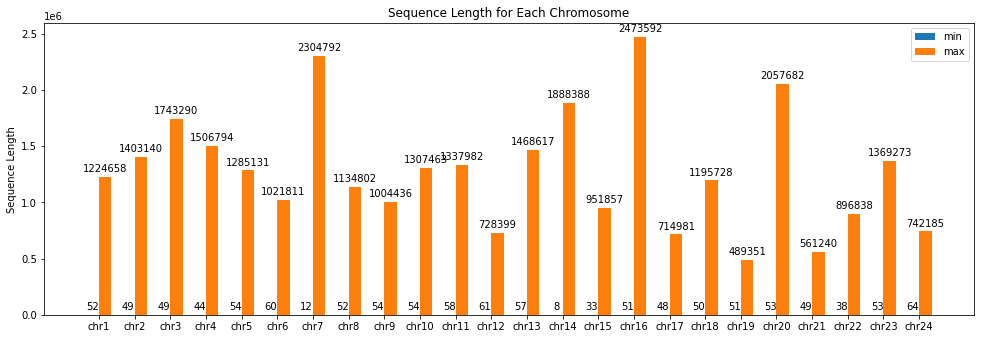

In [31]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

labels = chrs
x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, min_axis, width, label='min')
rects2 = ax.bar(x + width/2, max_axis, width, label='max')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Sequence Length')
ax.set_title('Sequence Length for Each Chromosome')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()
fig.set_size_inches(15, 5)

plt.show()
